In [45]:
import os

from descartes.patch import PolygonPatch
import joblib
import geopandas as gpd
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [46]:
def load_zeropoint(zpf):
    zeropoint = pd.read_csv(zpf, names=["ts", "avg"], header=0)
    zeropoint["ts"] = pd.to_datetime(zeropoint["ts"])
    zeropoint = zeropoint.sort_values("ts").set_index("ts")
    return zeropoint.resample('10T').mean()

zeropoint_d6 = load_zeropoint("weather_results/d6/2017-09-28.csv")
zeropoint_d9 = load_zeropoint("weather_results/d9/2017-09-28.csv")

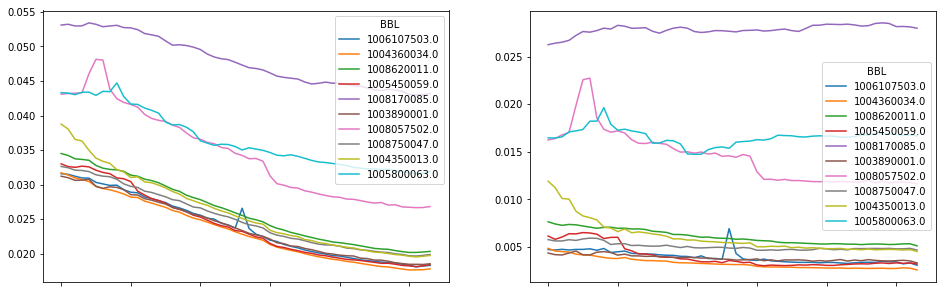

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
samp = np.random.choice(final_light_d6.columns, 10, replace=False)
final_light_d6[samp].plot(ax=ax1)
final_light_d6.apply(lambda x: x - zeropoint_d6["avg"])[samp].plot(ax=ax2)

(2800,
 3600,
 3800,
 4600,
 (3840, 5120),
 '/uofs15tb_gpfs/data/2017-09-28_night/0_d9_1506646816.png',
 '/uofs15tb_gpfs/data/2017-09-28_night/3148_d9_1506679190.png',
 0.036940154)

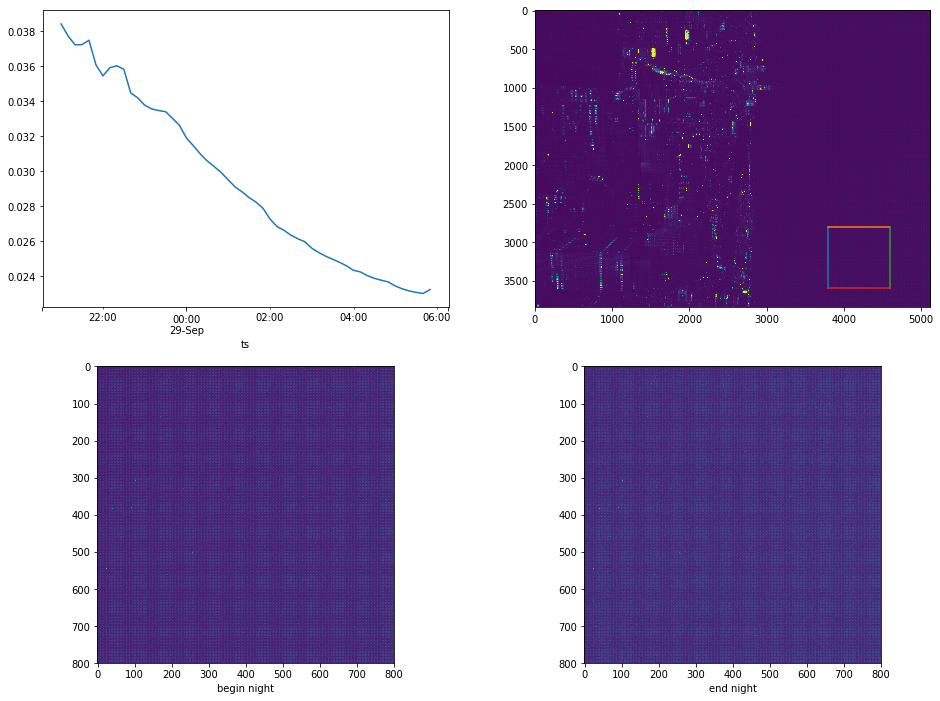

In [56]:
import weather
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
(ax1, ax2, ax3, ax4) = axes.flatten()
zeropoint_d9["avg"].plot(ax=ax1)
ims = weather.images_for_night("2017-09-28", 'd9')
ax2.imshow(plt.imread(ims[0]))
x1, x2, y1, y2 = weather.d9_skypatch
ax2.plot( [x1, x1], [y1, y2])
ax2.plot( [x1, x2], [y1, y1],)
ax2.plot([x2, x2], [y1, y2])
ax2.plot([x1, x2], [y2, y2])
ax3.imshow(plt.imread(ims[0])[y1:y2, x1:x2])
ax3.set_xlabel("begin night")
ax4.imshow(plt.imread(ims[-1])[y1:y2, x1:x2])
ax4.set_xlabel("end night")
y1, y2, x1, x2, plt.imread(ims[0]).shape, ims[0], ims[-1], plt.imread(ims[0])[y1:y2, x1:x2].mean()

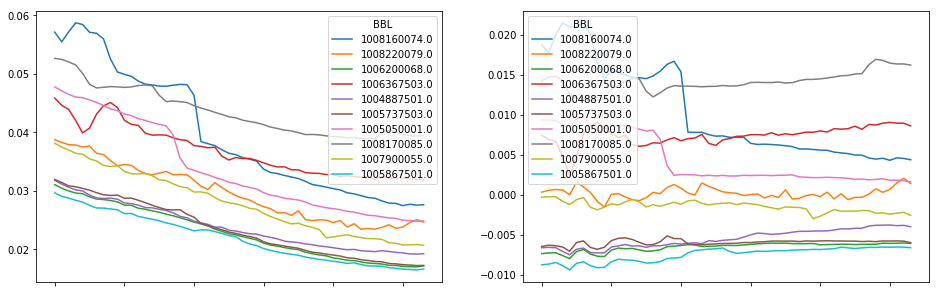

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
samp = np.random.choice(final_light_d9.columns, 10, replace=False)
final_light_d9[samp].plot(ax=ax1)
final_light_d9.apply(lambda x: x - zeropoint_d9["avg"])[samp].plot(ax=ax2)

In [58]:
d6_bbls = np.load("data/bimg_labels_d6.npy")
d9_bbls = np.load("data/bimg_labels_d9.npy")

# we will impute using surface area as our distance metric
pluto = gpd.read_file("data/pluto/MNMapPLUTO.shp")
pluto["surface_area"] = pluto["NumFloors"] * pluto.geometry.length

in_frame = pluto[(pluto.BBL.isin(np.unique(d6_bbls.ravel()))) | pluto.BBL.isin(np.unique(d9_bbls.ravel()))]
out_frame = pluto[(pluto.geometry.centroid.y < 215000) & ~pluto.index.isin(in_frame.index)]

final_light_d6 = pd.read_csv("data/bbl_2017-09-28/2017-09-28_d6_10m.csv")
final_light_d9 = pd.read_csv("data/bbl_2017-09-28/2017-09-28_d9_10m.csv")
for df in (final_light_d6, final_light_d9):
    del df["Unnamed: 0"]
    del df["lat"]
    del df["lng"]
final_light_d6 = final_light_d6.set_index("BBL").swapaxes(1, 0)
final_light_d9 = final_light_d9.set_index("BBL").swapaxes(1, 0)

In [59]:
# resolution strategy when we have 2 measurements: take the means
concatd = pd.concat((final_light_d6, final_light_d9))
final_light = concatd.groupby(concatd.index).mean()


In [60]:
if os.path.exists("data/impute_dists_centroid.gz"):
    dists = joblib.load("data/impute_dists_centroid.gz")
    nearest_idxs = joblib.load("data/impute_idxs_centroid.gz")
else:
    dists = []
    nearest_idxs = []
    for ix, building in out_frame.iterrows():
        if ix % 1000 == 0:
            print("at", ix)
        ds = in_frame.geometry.centroid.distance(building.geometry.centroid)
        dists.append(ds.min())
        nearest_idxs.append(ds.idxmin())
    joblib.dump(dists, "data/impute_dists_centroid.gz", 3)
    joblib.dump(nearest_idxs, "data/impute_idxs_centroid.gz", 3)
    
dists_arr = np.array(dists)

out_reset = out_frame.reset_index()
out_reset["dist"] = dists_arr


In [82]:
nearest_neighbors = [np.abs(in_frame.surface_area - osa).sort_values()[:10].index\
                     for osa in out_frame.surface_area]
out_reset["nearest_ix"] = nearest_neighbors

nearest_neighbors_100 = [np.abs(in_frame.surface_area - osa).sort_values()[:100].index\
                     for osa in out_frame.surface_area]
out_reset["nearest_ix_100"] = nearest_neighbors_100

In [83]:
medians = []
for i, indices in enumerate(out_reset["nearest_ix"]):
    cbbl = in_frame.loc[indices].BBL
    median = final_light[cbbl].mean().median()
    medians.append((i, median))
medians = np.array(medians, dtype=[('ix', int), ('median', np.float64)])

medians_100 = []
for i, indices in enumerate(out_reset["nearest_ix_100"]):
    cbbl = in_frame.loc[indices].BBL
    median = final_light[cbbl].mean().median()
    medians_100.append((i, median))
medians_100 = np.array(medians_100, dtype=[('ix', int), ('median', np.float64)])


(array([2314., 5725., 3543., 1249.,  364.,  196.,  149.,   40.,   17.,
          24.]),
 array([-3.79946304, -3.72826186, -3.65706068, -3.58585951, -3.51465833,
        -3.44345716, -3.37225598, -3.30105481, -3.22985363, -3.15865245,
        -3.08745128]),
 <a list of 10 Patch objects>)

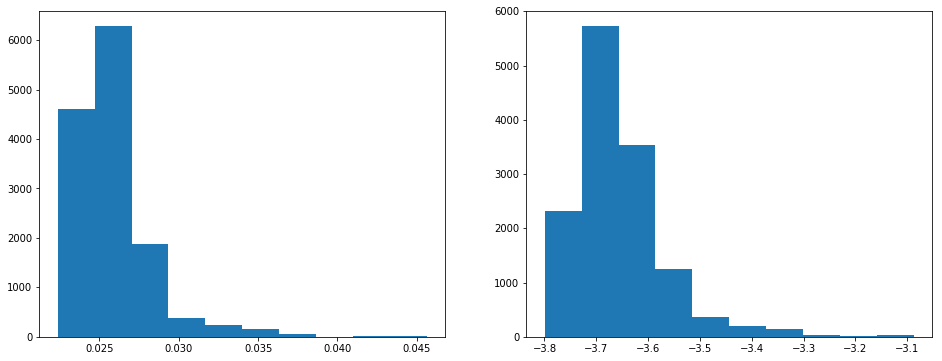

In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.hist(medians['median'])
ax2.hist(np.log(medians['median']))

In [90]:
medians_sorted = np.sort(medians, order='median')
medians_100_sorted = np.sort(medians_100, order='median')

In [102]:
colors = ['red'] * 4 + ['orange'] * 4 + ['yellow'] * 4 + ['green'] * 4
indices = [medians_sorted[int(len(medians) * (i / 16))] for i in range(15)] + [medians_sorted[-1]]
# 0 / 16 .. 14/16
indices_100 = [medians_100_sorted[int(len(medians) * (i / 16))] for i in range(15)] + [medians_100_sorted[-1]]


(0.021221023030834275, 0.046779838496922146)

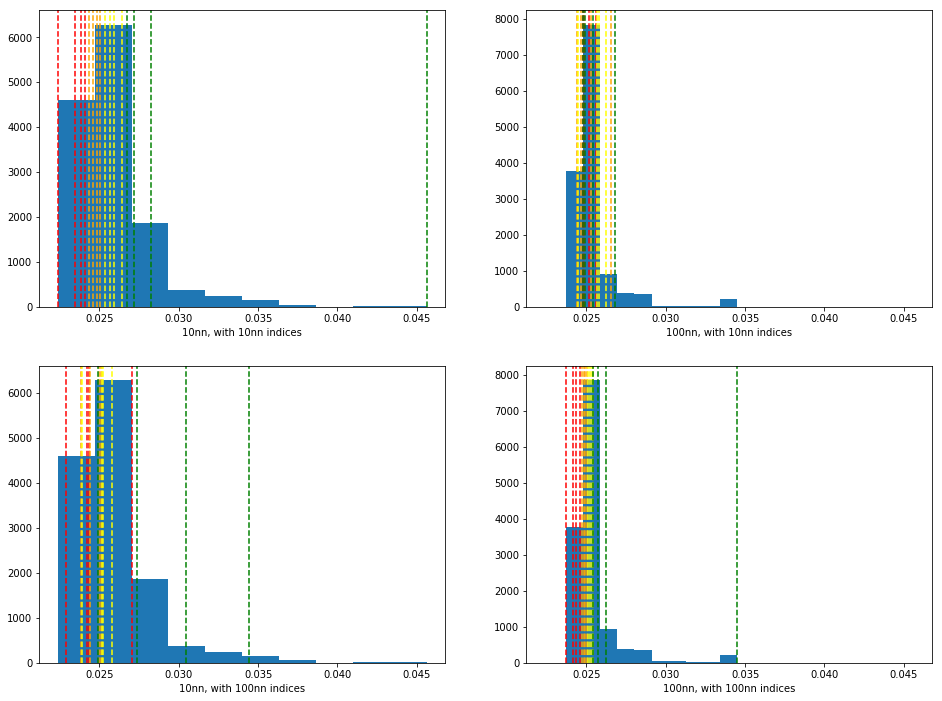

In [106]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
(ax1, ax2, ax3, ax4) = axes.flatten()
ax1.hist(medians['median'])
for i, ix in enumerate(indices):
    ax1.axvline(ix[1], linestyle='dashed', color=colors[i])
ax1.set_xlabel("10nn, with 10nn indices")

ax2.hist(medians_100['median'])
for i, ix in enumerate(indices):
    ixs = out_reset.loc[ix[0]].nearest_ix_100
    cbbl = in_frame.loc[ixs].BBL
    med = final_light[cbbl].mean().median()
    ax2.axvline(med, linestyle='dashed', color=colors[i])
ax2.set_xlabel("100nn, with 10nn indices")
ax2.set_xlim(ax1.get_xlim())

ax3.hist(medians['median'])
for i, ix in enumerate(indices_100):
    ixs = out_reset.loc[ix[0]].nearest_ix
    cbbl = in_frame.loc[ixs].BBL
    med = final_light[cbbl].mean().median()
    ax3.axvline(med, linestyle='dashed', color=colors[i])
ax3.set_xlabel("10nn, with 100nn indices")


ax4.hist(medians_100['median'])
for i, ix in enumerate(indices_100):
    ixs = out_reset.loc[ix[0]].nearest_ix_100
    cbbl = in_frame.loc[ixs].BBL
    med = final_light[cbbl].mean().median()
    ax4.axvline(med, linestyle='dashed', color=colors[i])
ax4.set_xlabel("100nn, with 100nn indices")
ax4.set_xlim(ax1.get_xlim())


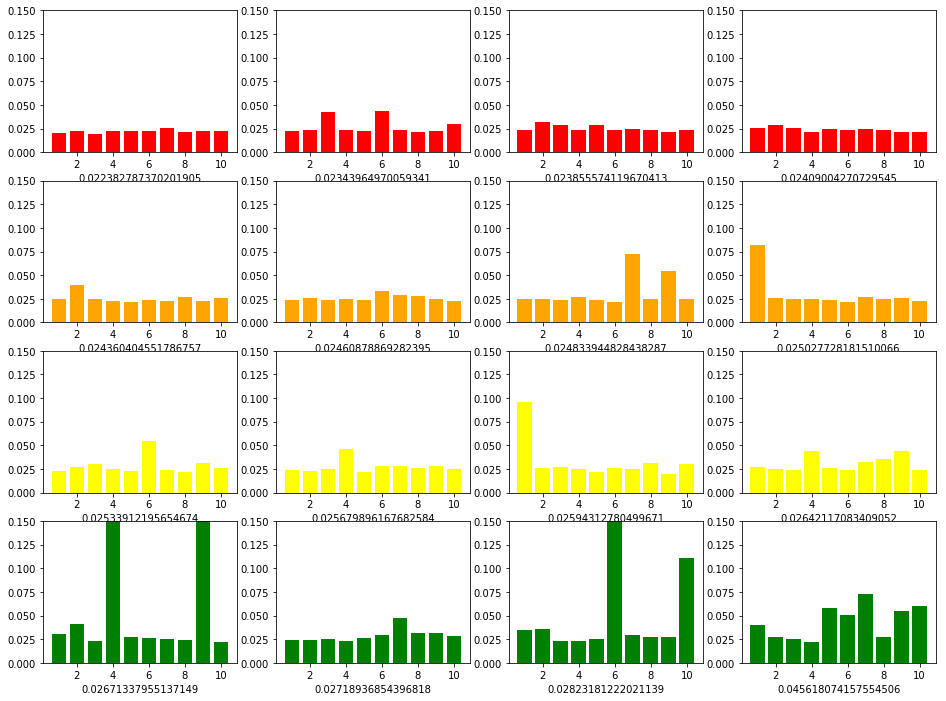

In [110]:
fig, axes = plt.subplots(4, 4, figsize=(16, 12))
axes = axes.flatten()
for i, (ax, ixs) in enumerate(zip(axes, out_reset.loc[[i[0] for i in indices]]["nearest_ix"])):
    cbbl = in_frame.loc[ixs].BBL
    means = final_light[cbbl].mean()
    ax.bar(range(1, 11), means, color=colors[i])
    ax.set_xlabel("{}".format(means.median()))
    ax.set_ylim([0, .15])

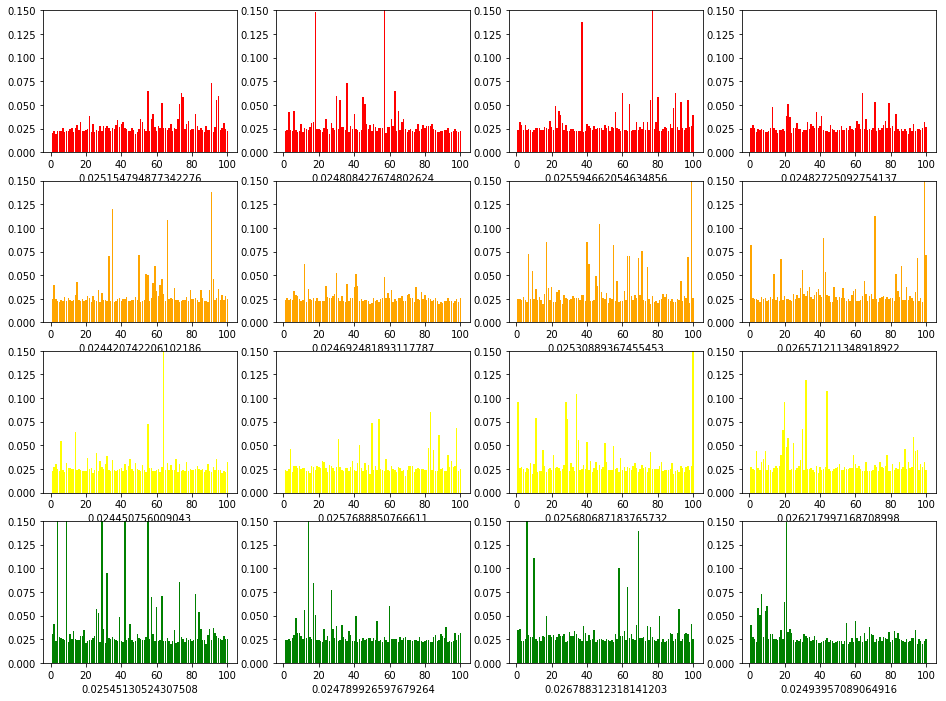

In [109]:
fig, axes = plt.subplots(4, 4, figsize=(16, 12))
axes = axes.flatten()
for i, (ax, ixs) in enumerate(zip(axes, out_reset.loc[[i[0] for i in indices]]["nearest_ix_100"])):
    cbbl = in_frame.loc[ixs].BBL
    means = final_light[cbbl].mean()
    ax.bar(range(1, 101), means, color=colors[i])
    ax.set_xlabel("{}".format(means.median()))
    ax.set_ylim([0, .15])

16

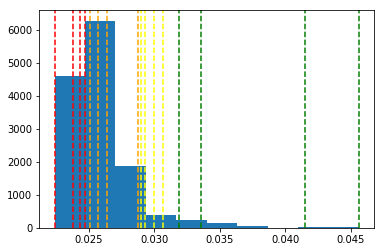

In [80]:
frac = int(10 * len(medians) / 11)
lmedians =  medians_sorted[:frac]
umedians = medians_sorted[frac:]

indices_2 = [lmedians[int(len(lmedians) * (i / 8))] for i in range(7)] +\
            [umedians[int(len(umedians) * (i / 8))] for i in range(7)] +\
            [umedians[-30], umedians[-1]]
fig, ax = plt.subplots()
ax.hist(medians['median'])
for i, ix in enumerate(indices_2):
    ax.axvline(ix[1], linestyle='dashed', color=colors[i])
len(indices_2)

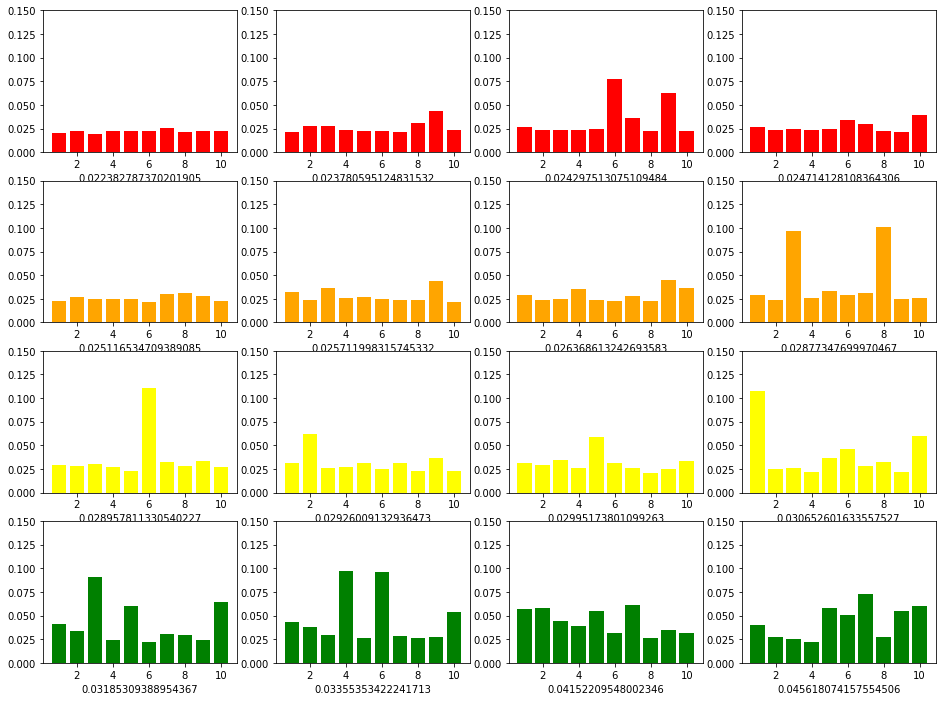

In [81]:
fig, axes = plt.subplots(4, 4, figsize=(16, 12))
axes = axes.flatten()
for i, (ax, ixs) in enumerate(zip(axes, out_reset.loc[[i[0] for i in indices_2]]["nearest_ix"])):
    cbbl = in_frame.loc[ixs].BBL
    means = final_light[cbbl].mean()
    ax.bar(range(1, 11), means, color=colors[i])
    ax.set_xlabel("{}".format(means.median()))
    ax.set_ylim([0, .15])

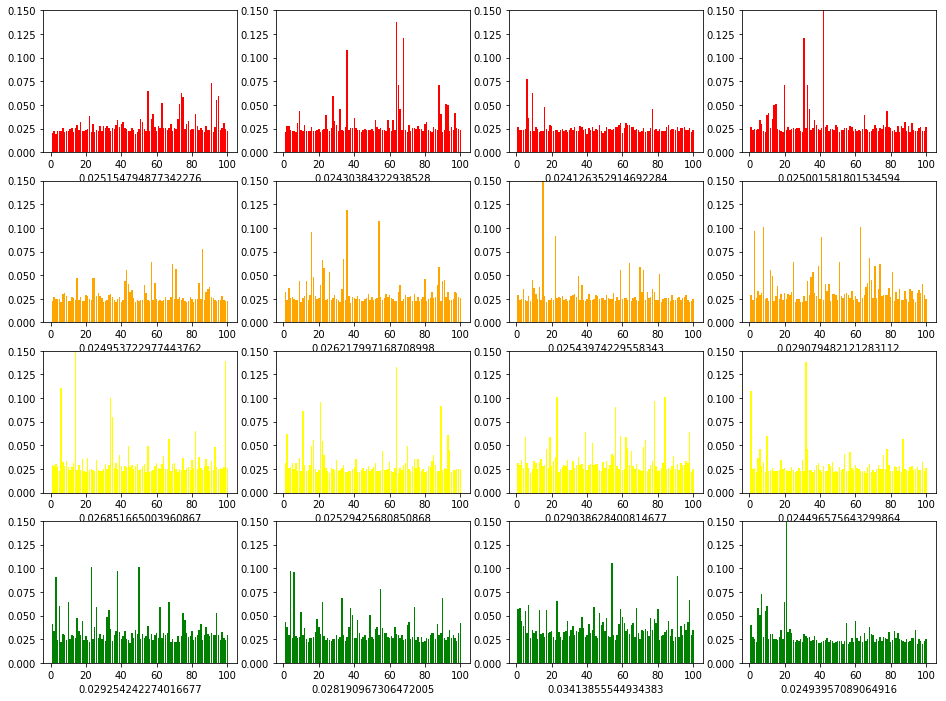

In [112]:
fig, axes = plt.subplots(4, 4, figsize=(16, 12))
axes = axes.flatten()
for i, (ax, ixs) in enumerate(zip(axes, out_reset.loc[[i[0] for i in indices_2]]["nearest_ix_100"])):
    cbbl = in_frame.loc[ixs].BBL
    means = final_light[cbbl].mean()
    ax.bar(range(1, 101), means, color=colors[i])
    ax.set_xlabel("{}".format(means.median()))
    ax.set_ylim([0, .15])